## Notebook showcasing the various options in Roodmus for analysis and visualisations
Each analysis functionality aims to compare output from a Single Particle Reconstruction workflow in RELION or CryoSPARC to the ground-truth information available from the generated Parakeet config files. The functions return a dictionary that can be converted to a pandas data frame for easy plotting and further analysis. This notebook allows the user as much flexibility as possible in creating their own analyses.

The provided tools include:
1. comparison of estimated and ground-truth CTF parameters
2. particle picking analysis

In [1]:
### imports
# general
import os
import mrcfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# roodmus
from roodmus.analysis.analyse_ctf import ctf_estimation
from roodmus.analysis.plot_ctf import plot_CTF, plot_defocus_scatter
from roodmus.analysis.analyse_picking import particle_picking
from roodmus.analysis.plot_picking import label_micrograph_picked, label_micrograph_truth, label_micrograph_truth_and_picked, plot_precision, plot_recall, plot_boundary_investigation, plot_overlap_investigation
from roodmus.analysis.analyse_alignment import alignment_3D
# from roodmus.analysis.plot_alignment import 


### CTF estimation


In [ ]:
### variables
config_dir = "data/6xm5_steered_Roodmus_1/mrc/"
meta_file = "data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs"
# meta_file = "data/6xm5_steered_Roodmus_1/RELION/job006_topaz.star"
plot_dir = "data/6xm5_steered_Roodmus_1/figures/"

verbose = True

In [ ]:
### analyse CTF estimation
analysis_ctf = ctf_estimation(meta_file, config_dir, verbose=verbose)
df_ctf = pd.DataFrame(analysis_ctf.results)
df_ctf

In [ ]:
### scatter plot of the estimated vs. the true defocus values
fig, ax = plot_defocus_scatter(df_ctf)
plt.rcParams["font.size"] = 20


In [ ]:
### plot the CTF estimation for a single micrograph
ugraph_index = 3 # which micrograph to plot

fig, ax = plot_CTF(df_ctf, config_dir, ugraph_index)

In [ ]:
### plot the CTF for the particle with the largest defocus error
delta_defocus = 0
for i, row in df_ctf.iterrows():
    defocusU = row["defocusU"]
    defocus_truth = row["defocus_truth"]
    if np.abs(defocusU - defocus_truth) > delta_defocus:
        delta_defocus = np.abs(defocusU - defocus_truth)
        max_error_index = int(row["ugraph_filename"].strip(".mrc"))

fig, ax = plot_CTF(df_ctf, config_dir, max_error_index)


### Particle picking

In [2]:
### variables
config_dir = "data/6xm5_steered_Roodmus_1/mrc/"
meta_files = [
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J298_picked_particles.cs",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J429_passthrough_particles_selected.cs",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J433_passthrough_particles.cs",
]

jobtypes = {
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs": "blob picking",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs": "2D classification",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J298_picked_particles.cs": "template picking",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J429_passthrough_particles_selected.cs": "2D classification 2",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J433_passthrough_particles.cs": "3D classification",   
}

# meta_files = [
#     "data/6xm5_steered_Roodmus_1/RELION/job015_manual.star",
#     "data/6xm5_steered_Roodmus_1/RELION/job006_topaz.star",
#     "data/6xm5_steered_Roodmus_1/RELION/job008_subset_selection.star",
# ]

# jobtypes = {
#     "data/6xm5_steered_Roodmus_1/RELION/job015_manual.star": "manual picking",	
#     "data/6xm5_steered_Roodmus_1/RELION/job006_topaz.star": "topaz picking",
#     "data/6xm5_steered_Roodmus_1/RELION/job008_subset_selection.star": "2D classification",
# }

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True

In [3]:
### analyse the particle picking
for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis_picking = particle_picking(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose) # creates the class
    else:
        analysis_picking.compute(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file


loading metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs...
loaded metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs. determined file type: cs


dictionaries now contain 358378 particles and 0 true particles
added 358378 particles from data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs


loading micrographs: 100%|██████████| 200/200 [00:49<00:00,  4.02it/s, micrograph=000199.mrc]


loaded ground-truth particle positions from config files
dictionaries now contain 358378 particles and 50000 true particles
added 50000 particles from data/6xm5_steered_Roodmus_1/mrc/
loading metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs...
loaded metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs. determined file type: cs


dictionaries now contain 370012 particles and 50000 true particles
added 11634 particles from data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs
loading metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J298_picked_particles.cs...
loaded metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J298_picked_particles.cs. determined file type: cs


dictionaries now contain 614339 particles and 50000 true particles
added 244327 particles from data/6xm5_steered_Roodmus_1/cryoSPARC/J298_picked_particles.cs
loading metadata from data/6xm5_steered_Roodmus_1/cryoSPARC

In [4]:
df_picked = pd.DataFrame(analysis_picking.results_picking)
df_truth = pd.DataFrame(analysis_picking.results_truth)
df_picked

,metadata_filename,ugraph_filename,position_x,position_y,ugraph_shape,defocus,class2D
0,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,2336.000000,885.333374,"[4000, 4000]",1544.884766,NaN
1,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,3125.333252,2474.666504,"[4000, 4000]",1544.884766,NaN
2,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,2197.333252,2336.000000,"[4000, 4000]",1544.884766,NaN
3,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,3680.000000,2634.666748,"[4000, 4000]",1544.884766,NaN
4,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,480.000000,906.666687,"[4000, 4000]",1544.884766,NaN
...,...,...,...,...,...,...,...
640427,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,3424.000000,3637.333496,"[4000, 4000]",NaN,15.0
640428,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,1941.333252,1525.333252,"[4000, 4000]",NaN,20.0
640429,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,970.666626,426.666687,"[4000, 4000]",NaN,15.0
640430,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,3093.333252,3317.333252,"[4000, 4000]",NaN,15.0


In [ ]:
### plot the picked particles
ugraph_index = 0 # which micrograph to plot
metadata_index = 0 # which metadata file to plot

fig, ax = label_micrograph_picked(df_picked.groupby("metadata_filename").get_group(meta_files[metadata_index]), ugraph_index, config_dir, box_width=48, box_height=48, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)


In [ ]:
### plot the truth particles
ugraph_index = 3 # which micrograph to plot

fig, ax = label_micrograph_truth(df_truth, ugraph_index, config_dir, box_width=32, box_height=32, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)


In [ ]:
### plot the truth and picked particles
ugraph_index = 3 # which micrograph to plot
metadata_index = 4 # which metadata file to plot

fig, ax = label_micrograph_truth_and_picked(df_picked.groupby("metadata_filename").get_group(meta_files[metadata_index]),
                                             df_truth, ugraph_index, config_dir, box_width=48, box_height=48, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)


In [5]:
### compute precision and recall
df_precision, df_picked = analysis_picking.compute_precision(df_picked, df_truth, verbose=verbose)
df_precision


for each micrograph, for each metadata file, compute the precision, recall and multiplicity
speed of computation depends on the number of particles in the micrograph. progressbar is not accurate
total number of groups to loop over: 997
number of micgrographs: 200
number of metadata files: 5
starting loop over groups


computing precision: 100%|██████████| 997/997 [02:30<00:00,  6.61it/s, precision=1, recall=0.272, multiplicity=0.272]     


time taken to compute precision: 152.1675500869751


,metadata_filename,ugraph_filename,defocus,class2D,num_particles_picked,num_particles_truth,TP,FP,FN,precision,recall,multiplicity
0,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,1544.884766,NaN,1776,250,245,1531,40,0.137950,0.859649,0.980
1,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000001.mrc,2200.916748,NaN,1803,250,251,1552,36,0.139212,0.874564,1.004
2,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000002.mrc,2703.475098,NaN,1765,250,256,1509,32,0.145042,0.888889,1.024
3,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000003.mrc,2798.346680,NaN,1795,250,261,1534,32,0.145404,0.890785,1.044
4,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000004.mrc,1490.031128,NaN,1777,250,237,1540,50,0.133371,0.825784,0.948
...,...,...,...,...,...,...,...,...,...,...,...,...
992,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000195.mrc,NaN,23.0,55,250,55,0,195,1.000000,0.220000,0.220
993,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000196.mrc,NaN,23.0,36,250,29,7,221,0.805556,0.116000,0.116
994,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000197.mrc,NaN,20.0,24,250,18,6,232,0.750000,0.072000,0.072
995,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000198.mrc,NaN,13.0,48,250,46,2,204,0.958333,0.184000,0.184


In [ ]:
### plot boxplot for precision and recall
fig, ax = plot_precision(df_precision, jobtypes)
fig, ax = plot_recall(df_precision, jobtypes)


In [ ]:
### alternatively, plot the precision and recall in the same plot
df = df_precision.melt(id_vars=["metadata_filename", "ugraph_filename", "defocus", "TP", "FP", "FN", "multiplicity", "num_particles_picked", "num_particles_truth"])

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x="metadata_filename", y="value", data=df, ax=ax, fliersize=0, palette="RdYlBu", hue="variable")
ax.set_ylabel("")
ax.set_xlabel("")
# change the xtix labels to the jobtypes
ax.set_xticklabels([jobtypes[meta_file] for meta_file in meta_files])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# add legend below axis
ax.legend().set_visible(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(1.1, 0.85))
fig.tight_layout()



In [ ]:
### plot the picked particles, now with the TP and FP marked in green and red
ugraph_index = 0 # which micrograph to plot
metadata_index = 0 # which metadata file to plot

fig, ax = label_micrograph_picked(df_picked.groupby("metadata_filename").get_group(meta_files[metadata_index]), ugraph_index, config_dir, box_width=48, box_height=48, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)

In [ ]:
### plot the distribution of the particles in the ugraphs in x, y, and z directions
metadata_index = 2 # which metadata file to plot
bin_width = [100, 100, 10] # bin width for x, y, z
axis = ["x", "y", "z"]

metadata_filename = meta_files[metadata_index]
for a, bnwdth in zip(axis, bin_width):
    fig, ax = plot_boundary_investigation(df_truth, df_picked, metadata_filename, bnwdth, axis=a)

In [ ]:
df_overlap = analysis_picking.compute_overlap(df_picked, df_truth, verbose=verbose)
df_overlap

In [ ]:
### plot the overlap between the picked and truth particles
metadata_index = 0 # which metadata file to plot. If None, all metadata files are plotted

metadata_filename = meta_files[metadata_index]
fig, ax = plot_overlap_investigation(df_overlap, metadata_filename, jobtypes=jobtypes)


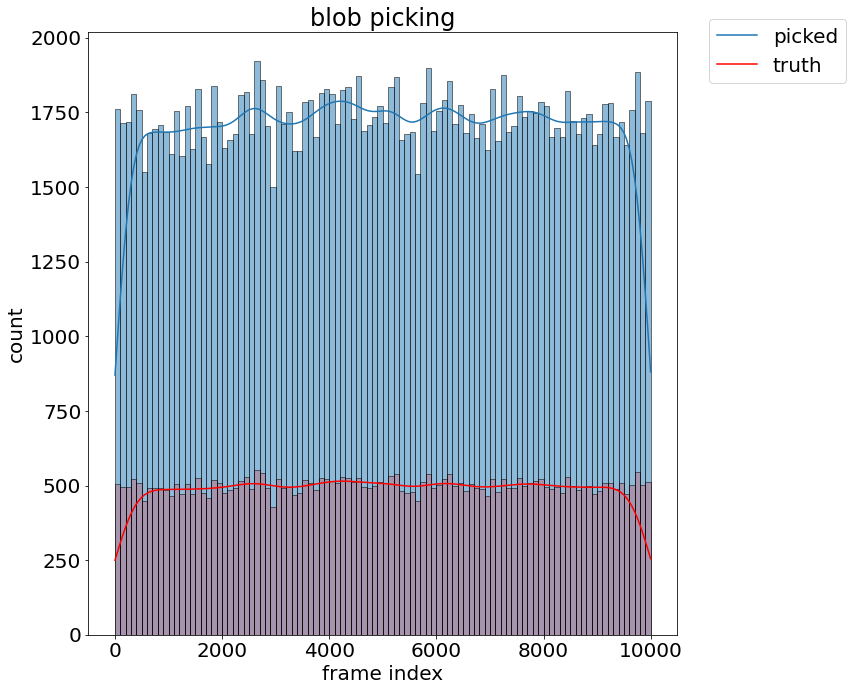

In [20]:
### plot the distribution of trajectory frames in a metadata file
metadata_index = 0 # which metadata file to plot
df_picked["closest_pdb_index"] = df_picked["closest_pdb"].apply(lambda x: int(x.split("_")[-1].split(".")[0]))
# set the closest_pdb_index to np.nan if the particle is not closer to a truth particle thatn the particle diameter
df_picked.loc[df_picked["closest_dist"] > particle_diameter, "closest_pdb_index"] = np.nan
df_truth["pdb_index"] = df_truth["pdb_filename"].apply(lambda x: int(x.split("_")[-1].split(".")[0]))

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(figsize = (10, 10))
sns.histplot(df_picked.groupby("metadata_filename").get_group(meta_files[metadata_index])["closest_pdb_index"], ax=ax, bins=100, kde=True)
sns.histplot(df_truth["pdb_index"], ax=ax, bins=100, kde=True, color="red", alpha=0.2)
ax.set_xlabel("frame index")
ax.set_ylabel("count")
ax.set_title(jobtypes[meta_files[metadata_index]])
fig.tight_layout()
fig.legend(["picked", "truth"], loc='lower center', ncol=1, bbox_to_anchor=(1.1, 0.85))



### 3D alignment

In [ ]:
### variables
config_dir = "data/6xm5_steered_Roodmus_1/mrc/"
meta_file = "data/6xm5_steered_Roodmus_1/cryoSPARC/J433_005_particles.cs" # must contain the 3D particle poses

verbose = True

In [ ]:
from importlib import reload
import roodmus.analysis.analyse_alignment
reload(roodmus.analysis.analyse_alignment)
from roodmus.analysis.analyse_alignment import alignment_3D
import roodmus.analysis.utils
reload(roodmus.analysis.utils)

import pandas as pd

In [ ]:
analysis_alignment = alignment_3D(meta_file, config_dir, load_all_configs=True, verbose=verbose) # creates the class
df_alignment_estimated = pd.DataFrame(analysis_alignment.results_picking)
df_alignment_truth = pd.DataFrame(analysis_alignment.results_truth)
df_alignment_truth

In [ ]:
### plot the alignment
grid = sns.jointplot(x="euler1", y="euler2", data=df_alignment_estimated, kind="hex", color="k", gridsize=50, bins="log", cmap="viridis")
grid.ax_joint.set_xlabel("Euler 1")
grid.ax_joint.set_ylabel("Euler 2")
grid.fig.set_size_inches(14, 7)
# adjust the x and y ticks to show multiples of pi
grid.ax_joint.set_xticks([-np.pi, -3/4*np.pi, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3/4*np.pi, np.pi])
grid.ax_joint.set_xticklabels(["$-\pi$", "$-3/4\pi$", "$-\pi/2$", "$-\pi/4$", "$0$", "$\pi/4$", "$\pi/2$", "$3/4\pi$", "$\pi$"])
grid.ax_joint.set_yticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
grid.ax_joint.set_yticklabels(["$-\pi/2$", "$-\pi/4$", "$0$", "$\pi/4$", "$\pi/2$"])

# repeat for the true particles
grid = sns.jointplot(x="euler1", y="euler2", data=df_alignment_truth, kind="hex", color="k", gridsize=50, bins="log", cmap="viridis")
grid.ax_joint.set_xlabel("Euler 1")
grid.ax_joint.set_ylabel("Euler 2")
grid.fig.set_size_inches(14, 7)
# adjust the x and y ticks to show multiples of pi
grid.ax_joint.set_xticks([-np.pi, -3/4*np.pi, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3/4*np.pi, np.pi])
grid.ax_joint.set_xticklabels(["$-\pi$", "$-3/4\pi$", "$-\pi/2$", "$-\pi/4$", "$0$", "$\pi/4$", "$\pi/2$", "$3/4\pi$", "$\pi$"])
grid.ax_joint.set_yticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
grid.ax_joint.set_yticklabels(["$-\pi/2$", "$-\pi/4$", "$0$", "$\pi/4$", "$\pi/2$"])



### Misc investigations